# Particle Filtering: How and Why it works

### Use cases for Particle Filter

1. Multi-modal problems: Tracking multiple vehicles on a highway using radar data. Each vehicle represents a different mode in the state distribution, and the particle filter can handle the multiple hypotheses effectively.

2. Occluded Objects : In computer vision, a pedestrian walking behind a parked car becomes temporarily hidden from a camera's view. A particle filter can predict the pedestrian's position during occlusion by maintaining multiple possible states.

3. Systems with non-linear behavior : An aircraft navigating through turbulent weather where wind forces cause non-linear effects on its trajectory. Another example is a robot arm with joint friction and backlash, leading to non-linear motion dynamics.

4. Systems providing non-linear measurements : A robot using a laser rangefinder measures distances to obstacles. Converting these measurements to Cartesian coordinates involves trigonometric functions, introducing non-linearity.

5. System with non-gaussian noise : A sensor affected by electromagnetic interference, causing occasional large errors (outliers) in measurements. The noise distribution might be heavy-tailed (e.g., a Cauchy distribution) rather than Gaussian.

6. System variables changing continiously : the object's position and velocity can smoothly change over time.

7. multivariate problem: we want to track several attributes, such as position, velocity, turn rates, etc.

8. Unknown system model : we may not know the process model of the system.

#### None of the following filters will work well with all of the above constraints:

1. Discrete Bayes Fitler : Suitable for discrete state spaces but not efficient for continuous or high-dimensional problems.

2. Kalman Filter : Assumes linear system models and Gaussian noise, which limits its applicability to non-linear or non-Gaussian systems.

3. Unscented kalman Filter: Linearizes non-linear models around the current estimate, which can introduce significant errors if the system is highly non-linear.

4. Extended Kalman Filter : Handles non-linearities better than EKF but still assumes Gaussian noise and may not perform well with multi-modal distributions or non-Gaussian noise.



### What is it ? Tell me in Simple worlds 

Particle filters, sample a finite number of particles randomly throughout the state space. For instance, in the context of robot localization problem, the particles are distributed across the map of the robots environment.

*side note: Sampling simply means generating a set of random possible states (x,y,z, oritentation) of the robot from a probability distribution*

There are two main steps that you need to keep in mind: 

1. Predict 
2. Update 

And particle filter algorithm will just run on an iterative prediction-correction loop. The good thing is that it can estimate the states despite the process and measurement noise, which can be of any arbitrary non-gaussain distribution. Process noise is simply the uncertainty in how the system's state changes over time due to unpredictable influences or model inaccuracies while Measurement noise is uncertainty in the observations caused by sensor errors/noise.

Below you can view how a generic particle filter algorithm is structured

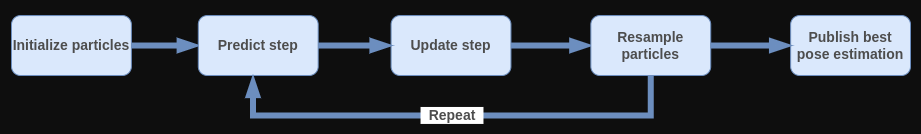

'Figure 1: Flow chart representing a generic Particle filter algorithm'

In [25]:
from IPython.display import display, Image
display(Image("flowchart.png", width=1000, height=1000), "Figure 1: Flow chart representing a generic Particle filter algorithm")

Let's discuss the basic particle filter algorithm for the robot localization problem. We have a robot whose orientation and velocity can be controlled by the user. It also has sensors that measure distances to obstacles. Both the sensors and the control mechanisms have noise, and our goal is to track the robot's position despite this uncertainty.

##### Before going any further, let's clarify what particles are:

* Particles: A particle is a simulated possible position and orientation of the robot. Each particle represents a belief about where the robot could be located. So, each particle has a position (x, y) and an orientation angle. Additionally, particles have an associated weight. You can think of all of the particles representing a probability distribution, locations where there are more particles represent a higher belief(that robot is at the position), and locations with fewer particles represents a lower belief(robot is likely not there). If there was a large clump of particles near a specific location that would imply that we are more certain that the robot is there.

* Weight: The weight indicates how likely it is that the particle represents the robot's true state. A higher weight means the particle more closely matches the robot's actual position.

##### Now, let's go through the steps of the particle filter algorithm:

*1. Randomly Generate Particles:* We start by randomly placing particles around an initial guessed position of the robot. If no guess is available, we can spread the particles uniformly across the entire map. Each particle is initialized with the same weight and has a certain (x,y) position and orientation.

*2. Predict the Next State of the Particles:* As the robot moves, we update all the particles based on the robot's control inputs and a motion model that includes some randomness to account for movement noise. For example, if the robot moves 1 meter forward and rotates 20 degrees, we move each particle accordingly but also add slight variations to simulate the uncertainty in motion.

*3. Update Weights:* We update the weights of all particles by comparing their predicted sensor readings to the actual sensor data received (e.g., from a 2D lidar). Particles whose predicted measurements closely match the actual sensor data receive higher weights, indicating they are more likely to represent the robot's true state.

*4. Resample:* We remove particles with low weights and replace them with new particles sampled from those with higher weights. This step concentrates the particles around the more probable (higher weight) states.

*5. Compute Estimate:* To estimate the robot's current position, we compute the weighted average of the particles' positions and orientations.

We repeat these steps multiple times. As the algorithm iterates, the particles converge around the robot's true position. This allows us to accurately track the robot's movement despite the noise in sensors and control inputs. Observe the gif below :) 

In [26]:
from IPython.display import display, HTML
display(HTML('<a href="https://drive.google.com/file/d/18LyPVCw7A8dPH7s46XfZRgiz9-doLP_u/view?usp=sharing" target="_blank">Figure 2: Animation of generic particle filter algorithm</a>'))

Let us go over the important steps in bit of a detail:

### Predict Step Exaplained 

In the predict step of the particle filter, each particle represents a possible position and orientation of the robot. Lets think about it, when we send a command to the robot—for example, to move forward by 0.1 meters and turn by 0.007 radians— we can also move all the particles exactly these amounts (wherever they might be). However, this would cause a problem because the robot's movements are not perfect (remember noise in control system of robot); it won't move exactly as commanded due to control noise and uncertainties.

To address this, we add randomness (noise) to the movement of each particle. Instead of moving each particle exactly by the commanded amounts, we add some noise to the command and move the particle with that modified command. This means each particle moves slightly differently, simulating the imperfections in the robot's actual movement.

    modified command = noise + user command 

By modeling the uncertainty in the robot's motion, the particle filter accurately captures the range of possible positions the robot could be in. This ensures that the filter correctly represents our belief about the robot's position as a probability distribution, accounting for the inherent noise in the control system.


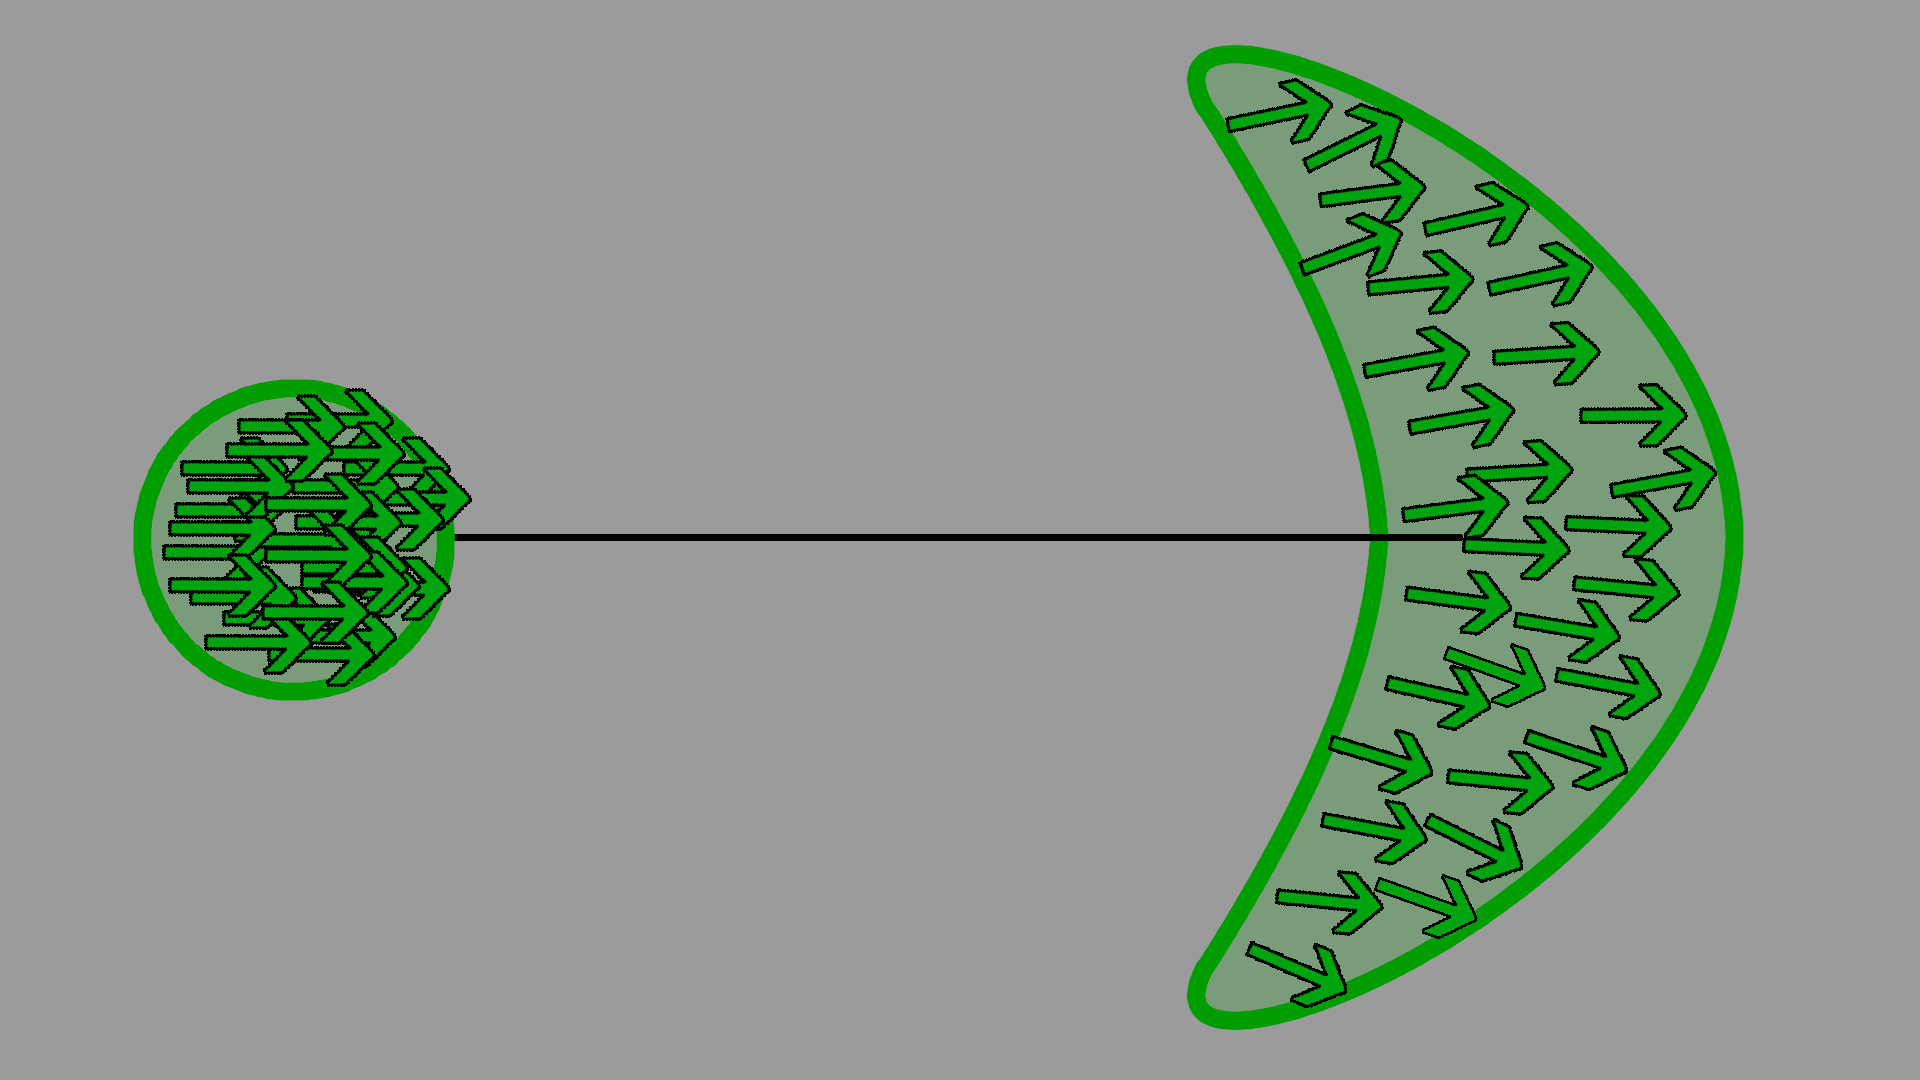

'Figure 3: During the predict step, particles are propagated forward by adding  some noise to user command according to odometry motion model.'

In [28]:
display(Image("predict_step_dispersion.png", width=400, height=400), "Figure 3: During the predict step, particles are propagated forward by adding  some noise to user command according to odometry motion model.")

### Update Step Explained 

Before diving into the update step of the particle filter algorithm, it's important to understand the concept of likelihood. Likelihood is a key idea in Bayes' theorem, and since the particle filter is based on Bayesian principles, grasping this concept is essential. 

Think of likelihood as a score that indicates how likely it is for something to happen, given some evidence.

#### So taking the robot localization problem, 

##### *Particles as Hypotheses:* 

Each particle represents a possible position and orientation of the robot—a hypothesis about where the robot might be.

##### *Calculating Likelihood:*

We compare the expected 2D sensor readings if the sensor was located at each of the particle's position to the actual sensor readings the robot receives. If a particle's expected readings closely match the actual readings, the likelihood for that particle is high. 

Example: Assume a particle A at x=1,y=1. Robot with sensor is at x=0, y=0. We would compute the sensor reading if the sensor was at the particle's position (x=1, y=1) and then compare by taking a difference of that sensor reading with the actual sensor reading at x=0,y=0 which is the true sensor reading. We do this for all the particles and proportional to that difference we assign a weight. 

##### *Updating Weights:*

The likelihood determines the weight of each particle. Particles with higher likelihoods (better matches to the observed/true data) receive higher weights.